## Predicting Water Quality

### General Libraries

In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

### 1. Data Exploration

In [3]:
# read the data
df = pd.read_csv("D:\ProjectData\water_potability.csv")

# check data frame shape
df.shape

(3276, 10)

In [4]:
# check column names and first few columns
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
# check data types
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [6]:
# check for missing values
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

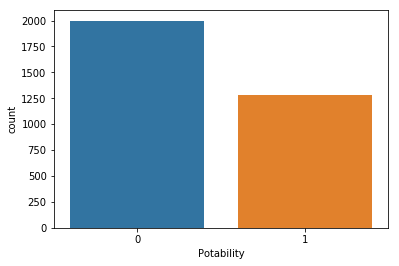

In [7]:
# check distribution of target variable
sns.countplot(data=df, x="Potability")

### 2. Data Preprocessing

There is no need for **data standardization** or **removal of missing values** as the intended algorithm to be used can handle both.

In [8]:
# split data into training and test set (here we use 90% training data and 10% testing data)

from sklearn.model_selection import train_test_split

X = df.drop(["Potability"], 1)
y = df.Potability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify = y, random_state=42)

### 3. Modelling and Model Optimization

In this project we look at a gradient boosting tree algorithm developed by Microsoft called **LightGBM**.

We look to fit this model and optimize three hyperparameters:
* **n_estimators:** Number of gradient boosted trees
* **learning_rate:** Controls model variance and bias.
* **max_depth:** Maximum tree depth

In [9]:
import lightgbm
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# define model

clf_lgbm = lightgbm.LGBMClassifier(seed = 1)


# define hyperparameter space for Bayesian Optimization

hyperparameters = {"n_estimators": Integer(2,1000), "learning_rate": Real(0.0001, 0.5), "max_depth": Integer(2,5)}


# perform bayesian optimization

clf_bo = BayesSearchCV(clf_lgbm, hyperparameters, cv =5, scoring = "roc_auc", n_iter = 100, random_state = 1)

bayes_search = clf_bo.fit(X_train, y_train)

# identify best hyperparameters and best score from bayesian optimization
print(f"BO Best hyperparameters: {bayes_search.best_params_}") 
print(f"BO Best score: {bayes_search.best_score_}")


BO Best hyperparameters: OrderedDict([('learning_rate', 0.02145244548302868), ('max_depth', 5), ('n_estimators', 458)])
BO Best score: 0.6633684819614334


In [10]:
# set optimized parameters and fit to whole training data

clf_lgbm.set_params(**bayes_search.best_params_)

clf_lgbm.fit(X_train, y_train)


LGBMClassifier(learning_rate=0.02145244548302868, max_depth=5, n_estimators=458,
               seed=1)

### 4. Model Evaluation

In [11]:
# generate set of predictions
y_pred = clf_lgbm.predict(X_test)

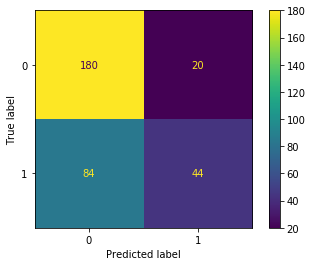

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [14]:
from sklearn.metrics import precision_score

precision_score(y_test, y_pred)

0.6875

### 5. Feature Importance

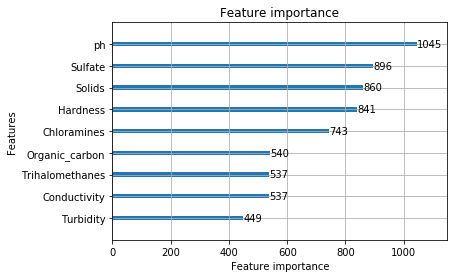

In [15]:
# feature importance

lightgbm.plot_importance(clf_lgbm)